# Inference example for trained 2D U-Net model on BraTS.
Takes a trained model and performs inference on a few validation examples.

In [1]:
!which python

/home/ubuntu/anaconda3/bin/python


In [9]:
%matplotlib inline
import os
import psutil
import numpy as np
import tensorflow as tf
import keras as K
import h5py

print (tf.__version__)

import matplotlib.pyplot as plt

1.10.0


Setup settings

In [3]:
data_path = os.path.join("../data/144x144/")
data_filename = "Task01_BrainTumour.h5"

output_path = os.path.join("./output/")
inference_filename = "unet_model_for_decathlon.hdf5"

epochs = 30  # Number of epochs to train

"""
If the batch size is too small, then training is unstable.
I believe this is because we are using 2D slicewise model.
There are more slices without tumor than with tumor in the
dataset so the data may become imbalanced if we choose too
small of a batch size. There are, of course, many ways
to handle imbalance training samples, but if we have
enough memory, it is easiest just to select a sufficiently
large batch size to make sure we have a few slices with
tumors in each batch.
"""
BATCH_SIZE = 128

# Using Adam optimizer
LEARNING_RATE = 0.0001 #0.00005  # 0.00005
WEIGHT_DICE_LOSS = 0.9  # Combined loss weight for dice versus BCE

FEATURE_MAPS = 32 # 32 is a good number, but requires about 16 GB of memory
PRINT_MODEL = True  # Print the model

# CPU specific parameters for multi-threading.
# These can help take advantage of multi-core CPU systems
# and significantly boosts training speed with MKL-DNN TensorFlow.
BLOCKTIME = 1
NUM_INTER_THREADS = 1
# Default is to use the number of physical cores available

# Figure out how many physical cores we have available
# Set floor to at least 2 threads
NUM_INTRA_THREADS = max(len(psutil.Process().cpu_affinity()),2)

CHANNELS_FIRST = False
USE_KERAS_API = True   # If true, then use Keras API. Otherwise, use tf.keras
# 28 DEC 2018: tf.keras has some bugs in the use of HDF5 and with the custom
# loss function. Recommend to use Keras API when in doubt.
USE_UPSAMPLING = True  # If true, then use bilinear interpolation. Otherwise, transposed convolution
USE_AUGMENTATION = False # Use data augmentation during training
USE_DROPOUT = False  # Use spatial dropout in model


In [4]:
def calc_dice(y_true, y_pred, smooth=1.):
    """
    Sorensen Dice coefficient
    """
    numerator = 2.0 * np.sum(y_true * y_pred) + smooth
    denominator = np.sum(y_true) + np.sum(y_pred) + smooth
    coef = numerator / denominator

    return coef

def dice_coef(y_true, y_pred, axis=(1, 2), smooth=1.):
    """
    Sorenson (Soft) Dice
    \frac{  2 \times \left | T \right | \cap \left | P \right |}{ \left | T \right | +  \left | P \right |  }
    where T is ground truth mask and P is the prediction mask
    """
    intersection = tf.reduce_sum(y_true * y_pred, axis=axis)
    union = tf.reduce_sum(y_true + y_pred, axis=axis)
    numerator = tf.constant(2.) * intersection + smooth
    denominator = union + smooth
    coef = numerator / denominator

    return tf.reduce_mean(coef)


def dice_coef_loss(target, prediction, axis=(1, 2), smooth=1.):
    """
    Sorenson (Soft) Dice loss
    Using -log(Dice) as the loss since it is better behaved.
    Also, the log allows avoidance of the division which
    can help prevent underflow when the numbers are very small.
    """
    intersection = tf.reduce_sum(prediction * target, axis=axis)
    p = tf.reduce_sum(prediction, axis=axis)
    t = tf.reduce_sum(target, axis=axis)
    numerator = tf.reduce_mean(intersection + smooth)
    denominator = tf.reduce_mean(t + p + smooth)
    dice_loss = -tf.log(2.*numerator) + tf.log(denominator)

    return dice_loss


def combined_dice_ce_loss(y_true, y_pred, axis=(1, 2), smooth=1.,
                          weight=0.9):
    """
    Combined Dice and Binary Cross Entropy Loss
    """
    return weight*dice_coef_loss(y_true, y_pred, axis, smooth) + \
        (1-weight)*K.losses.binary_crossentropy(y_true, y_pred)

def plot_results(model, imgs_validation, msks_validation, img_no, png_directory):
    """
    Calculate the Dice and plot the predicted masks for image # img_no
    """

    img = imgs_validation[[img_no], ]
    msk = msks_validation[[img_no], ]

    pred_mask = model.predict(img)

    dice_score = calc_dice(pred_mask, msk)

    print("Dice score for Image #{} = {:.4f}".format(img_no,
                                                     dice_score))

    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.imshow(img[0, :, :, 0], cmap="bone", origin="lower")
    plt.axis("off")
    plt.title("MRI Input", fontsize=20)
    plt.subplot(1, 3, 2)
    plt.imshow(msk[0, :, :, 0], origin="lower")
    plt.axis("off")
    plt.title("Ground truth", fontsize=20)
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask[0, :, :, 0], origin="lower")
    plt.axis("off")
    plt.title("Prediction\nDice = {:.4f}".format(dice_score), fontsize=20)

    plt.tight_layout()

    png_name = os.path.join(png_directory, "pred{}.png".format(img_no))
    plt.savefig(png_name, bbox_inches="tight", pad_inches=0)
    print("Saved png file to {}".format(png_name))

    


Below is the main

In [5]:

data_fn = os.path.join(data_path, data_filename)
model_fn = os.path.join(output_path, inference_filename)
print (data_fn)
print (model_fn)

../data/144x144/Task01_BrainTumour.h5
./output/unet_model_for_decathlon.hdf5


In [6]:
# Load data
df = h5py.File(data_fn, "r")
imgs_validation = df["imgs_validation"]
msks_validation = df["msks_validation"]

# Load model
model = K.models.load_model(model_fn, custom_objects={
"combined_dice_ce_loss": combined_dice_ce_loss,
"dice_coef_loss": dice_coef_loss,
"dice_coef": dice_coef})

# Create output directory for images
png_directory = "inference_examples"
if not os.path.exists(png_directory):
    os.makedirs(png_directory)

# Plot some results
# The plots will be saved to the png_directory
# Just picking some random samples.
indicies_validation = [40,61,400,1100,4385,5566,5673,6433,7864,8899,9003,9722,10591]
indicies_validation = [40]

Dice score for Image #40 = 0.9121
Saved png file to inference_examples/pred40.png
Dice score for Image #40 = 0.9121
Saved png file to inference_examples/pred40.png
Dice score for Image #40 = 0.9121
Saved png file to inference_examples/pred40.png
Dice score for Image #40 = 0.9121
Saved png file to inference_examples/pred40.png
Dice score for Image #40 = 0.9121
Saved png file to inference_examples/pred40.png
Dice score for Image #40 = 0.9121
Saved png file to inference_examples/pred40.png
Dice score for Image #40 = 0.9121
Saved png file to inference_examples/pred40.png
Dice score for Image #40 = 0.9121
Saved png file to inference_examples/pred40.png
350 ms ± 43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


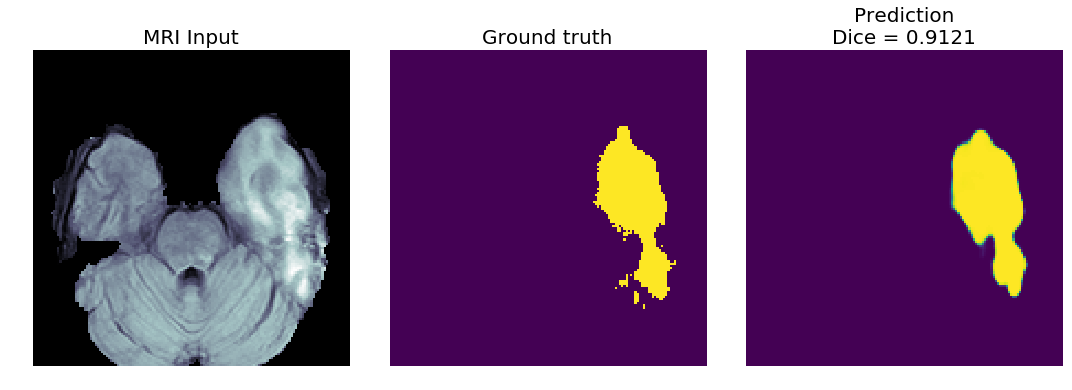

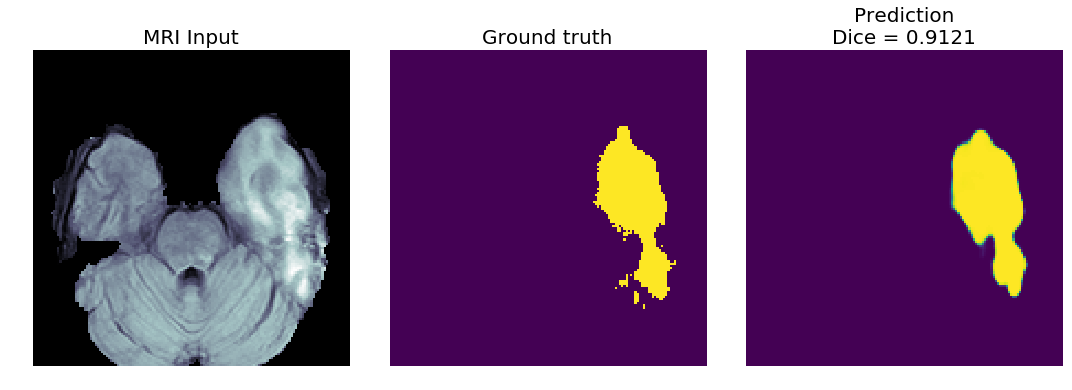

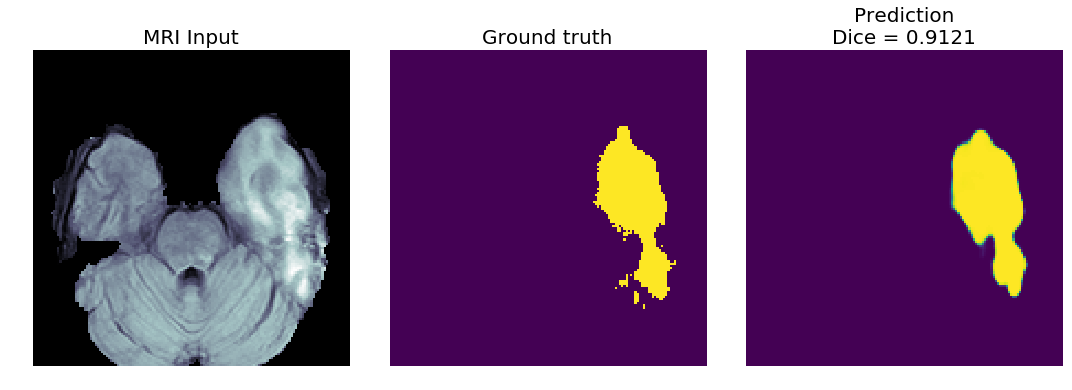

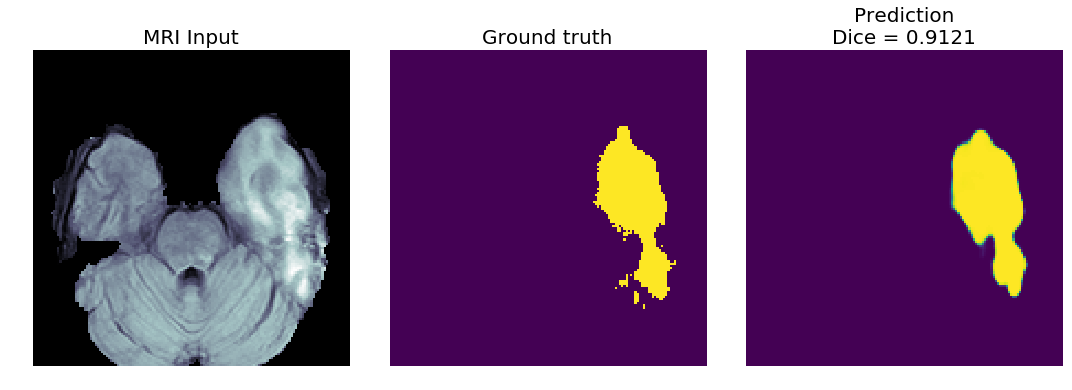

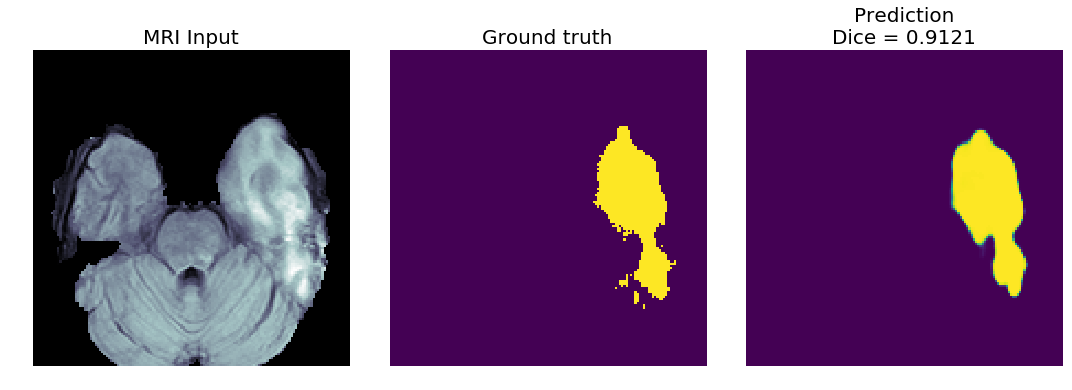

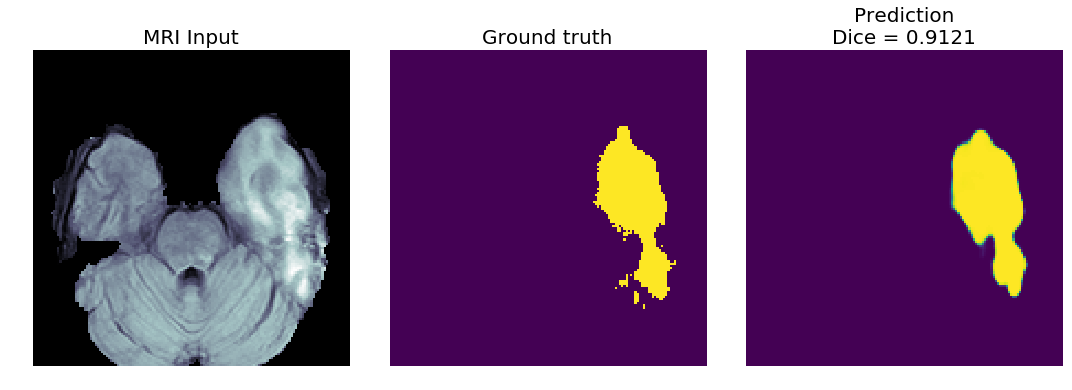

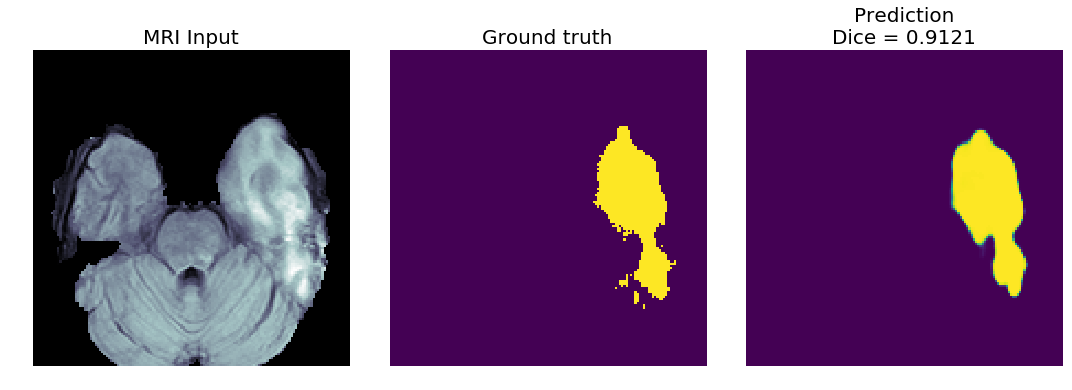

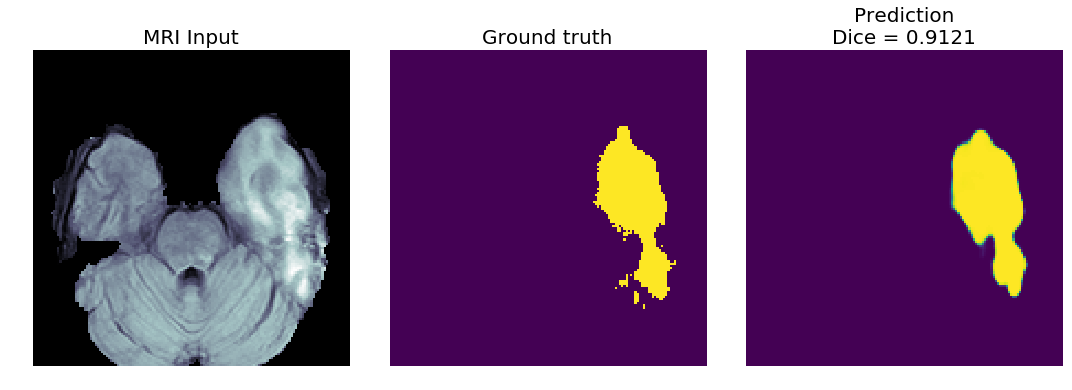

In [7]:
%%timeit
for idx in indicies_validation:
    plot_results(model, imgs_validation, msks_validation, idx, png_directory)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
   http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

SPDX-License-Identifier: EPL-2.0
